# OOS Prediction with missing data in PyMC3
This is a small notebook inspired by [a user question on Discourse](https://discourse.pymc.io/t/oos-predictions-with-missing-input-values/).

The ability to predict new data from old observations has long been considered as one of the golden rules of evaluating science and scientific theory. And in Bayesian modelling, this idea is especially natural: not only it maps new inputs into new outputs the same way as a deterministic model, it does so probabilistically, meaning that you also get the uncertainty of each prediction.  

Consider a linear regression problem: the data could be represented as a tuple ($X$, $y$) and we want to find the linear relationship which maps $X\to y$. $X$ is usually referred to as predictors, represented as a matrix (say k * n) so that it is easier to work with using linear algebra. In a setting where we have no missing data, we can write down the linear model as something like this (with weakly informative prior, and the intercept coded in $X$):

$$
\begin{align*}
    \sigma \sim \textrm{HalfCauchy}(0, 2.5) \\
    \beta \sim \textrm{Normal}(0, 10) \\
    \textrm{y} \sim \textrm{Normal}(\textrm{X}*\beta, \sigma)
\end{align*}
$$

A subtle point here to note here is that values in $X$ are usually considered as given, something trivial to measure, or has little noise (even noiseless). It could be true in some context: for example, $X$ is a dummy-code parameterization of different experimental groups. In general, if $X$ contains continuous measures (sometimes also referred to as covariates, which in psychology researchers usually analyse with ANCOVA etc.), it is silly to assume this measurement is noiseless. Measurement error as such is in general difficult to deal with in frequentistic statistics - the uncertainty in covariates just propagate to $y$ 
(e.g., see https://en.wikipedia.org/wiki/Propagation_of_uncertainty). However, in Bayesian Statistics, this is quite natural to model the uncertainty in covariates by considering the observed covariates in $X$ as some noisy realization of some _true_ latent variables:  

$$
\begin{align*}
    \sigma \sim \textrm{HalfCauchy}(0, 2.5) \\
    \beta \sim \textrm{Normal}(0, 10) \\
    \textrm{X_latent} \sim \textrm{Normal}(0, 10) \\
    \textrm{X} \sim \textrm{Normal}(\textrm{X_latent}, 1) \\
    \textrm{y} \sim \textrm{Normal}(\textrm{X_latent}*\beta, \sigma)
\end{align*}
$$

The latter was also shown to be a natural solution for missing data. 

In [11]:
# set up enviorment and generate data
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import matplotlib.gridspec as gridspec
%pylab inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['trace', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Generate data ($X$, $y$), and mask the design matrix $X$.
$X$ follows a Normal distribution with `Xmu = [0, 2]`, and the missing variable is masked using a numpy masked_array.

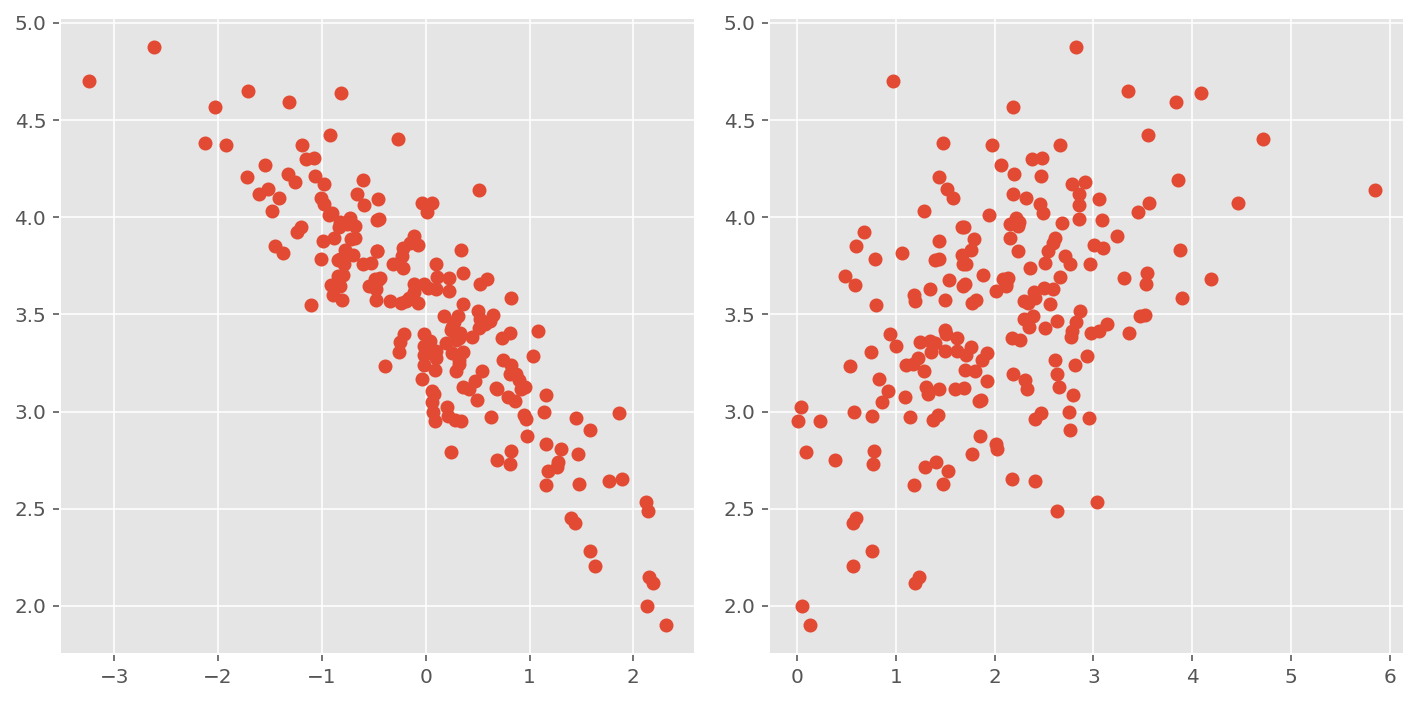

In [12]:
np.random.seed(42)
n0 = 200
# generate data with missing values
Xmu_ = np.array([0, 2])
x_train = np.random.randn(n0, 2) + Xmu_
beta_ = np.array([-.5, .25])
alpha_ = 3
sd_ = .1
y_train = alpha_ + sd_ * np.random.randn(n0) + np.dot(x_train, beta_.T)

plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0, 0])
ax0.plot(x_train[:, 0], y_train, 'o')
ax0 = plt.subplot(gs[0, 1])
ax0.plot(x_train[:, 1], y_train, 'o')
plt.tight_layout();

# Masks the covariates
mask = np.array(np.random.rand(n0, 2) < .015, dtype=int)

X_train = np.ma.masked_array(x_train, mask=mask)

In [13]:
# build model, fit, and check trace
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=(2,))
    
    Xmu = pm.Normal('Xmu', mu=0, sd=10, shape=(2,))
    X_modeled = pm.Normal('X', mu=Xmu, sd=1., observed=X_train)

    mu = alpha + tt.dot(X_modeled, beta)
    sd = pm.HalfCauchy('sd', beta=10)
    y = pm.Normal('y', mu=mu, sd=sd, observed=y_train)

In [14]:
model

In [15]:
model.free_RVs

[alpha, beta, Xmu, X_missing, sd_log__]

Displaying the free random variables (RVs) in the `model`, we see that `PyMC3` added a new RV `X_missing`, which we did not declared, into the model. It coded for the missing values in our design matrix $X$.  

Now we can sample from the posterior using NUTS and examinate the trace:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 53%|█████▎    | 791/1500 [00:19<00:03, 197.17it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.881618620446, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
 71%|███████   | 1064/1500 [00:21<00:02, 189.90it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 2 does not match the target. It is 0.894470562819, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
 95%|█████████▍| 1424/1500 [00:22<00:00, 322.29it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 3 does not match the target. It is 0.882355870377, but should b

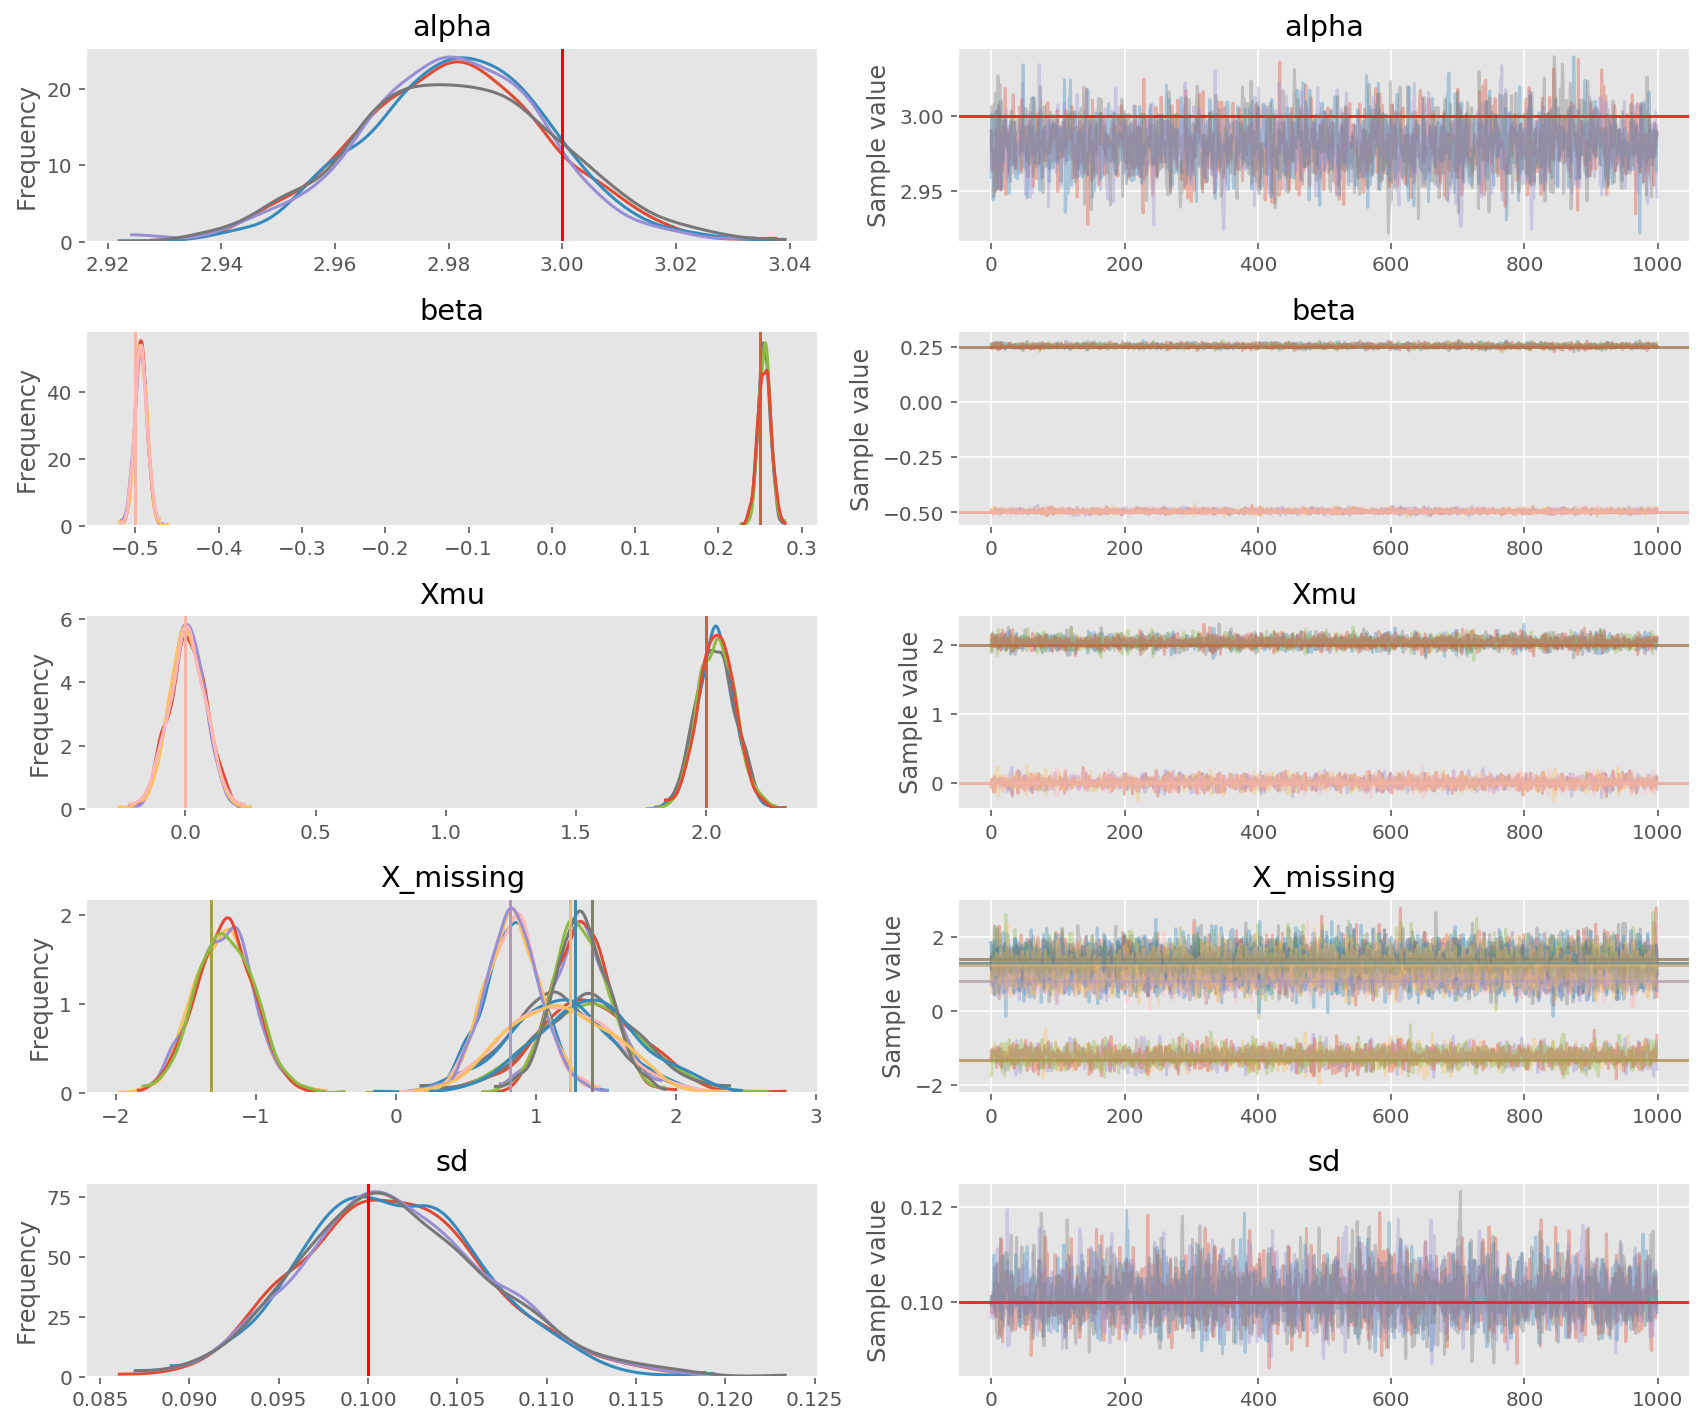

In [16]:
# inference
with model:
    trace = pm.sample(1000, njobs=4)

pm.traceplot(trace, 
             lines=dict(alpha=alpha_, 
                        beta=beta_, 
                        sd=sd_, 
                        Xmu=Xmu_,
                        X_missing=x_train[mask==1]));

As shown above, the parameters we are usually interested in (e.g., coefficients of the linear model $\beta$) could be recovered from the model nicely. Moreover, it gives a close estimation of the missing values in $X$. 

There are some warning of acceptance probability higher than target, but this is nothing to be too alarm of: sampling the missing values usually has a higher acceptance probability.

We can check how the fit is using posterior prediction checks:

100%|██████████| 200/200 [00:00<00:00, 818.56it/s]


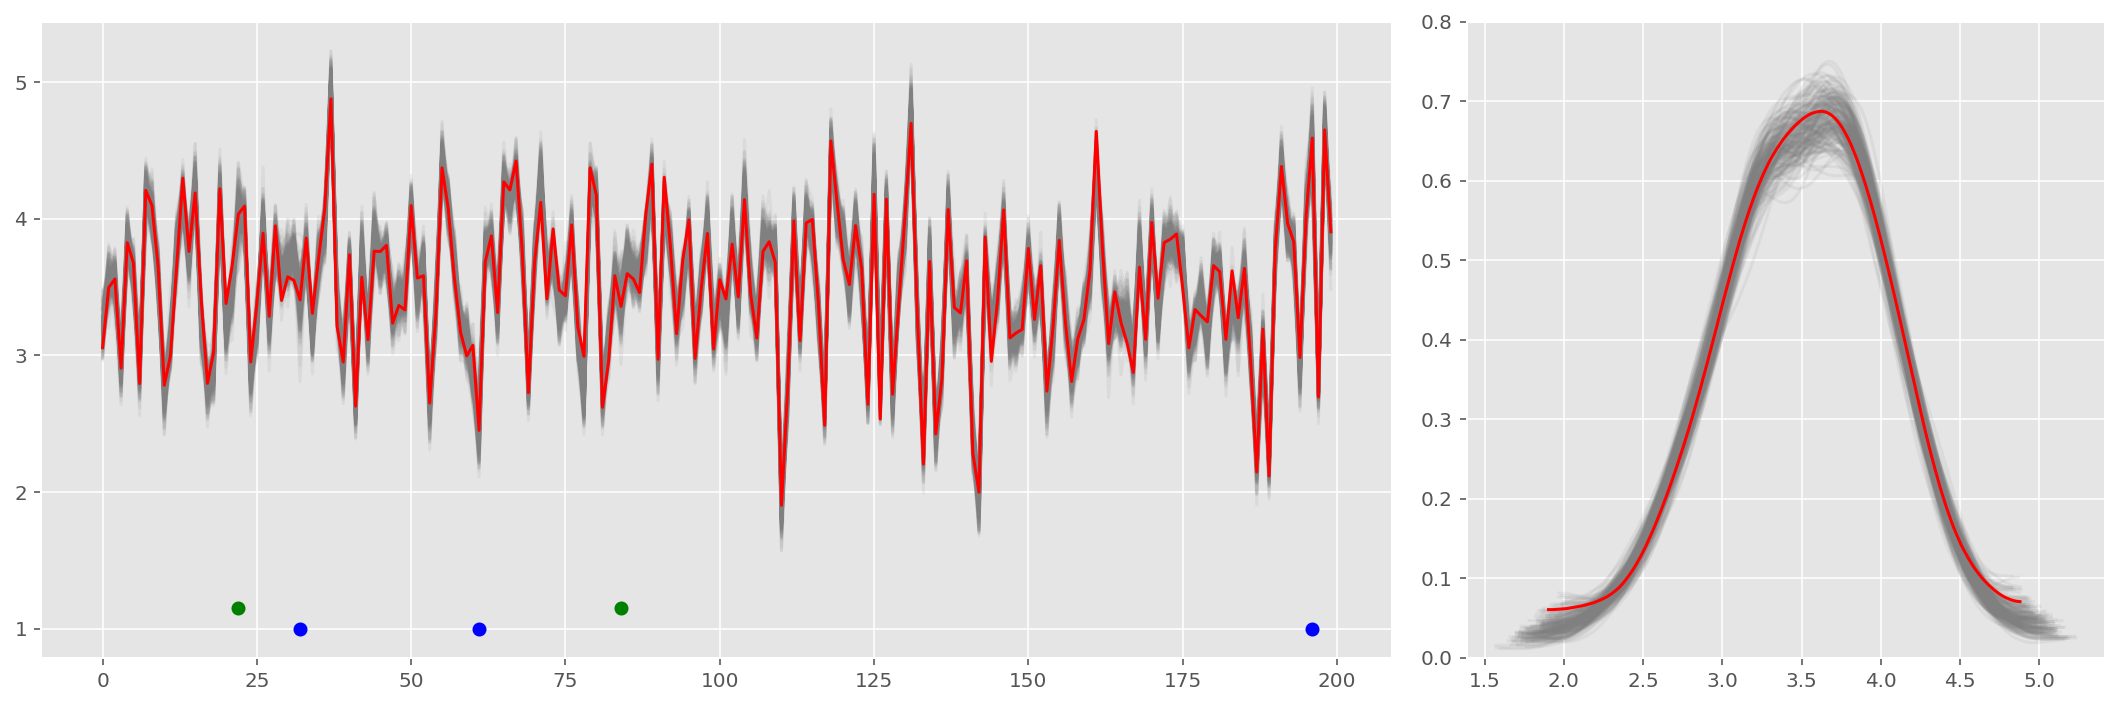

In [17]:
# posterior predictive checks on original data
ppc = pm.sample_ppc(trace, samples=200, model=model)

def plot_predict(ppc_y, y):
    plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3)
    ax0 = plt.subplot(gs[0, 0:2])
    ax0.plot(ppc_y.T, color='gray', alpha=.1)
    ax0.plot(y, color='r')
    
    ax1 = plt.subplot(gs[0, 2])
    for ppc_i in ppc_y:
        pm.kdeplot(ppc_i, ax=ax1, color='gray', alpha=.1)
    pm.kdeplot(y, ax=ax1, color='r')
    plt.tight_layout()
    return ax0, ax1

ax0, ax1 = plot_predict(ppc['y'], y_train)
ax0.plot(np.where(mask[:, 0]), 1, 'o', color='b');
ax0.plot(np.where(mask[:, 1]), 1.15, 'o', color='g');
ax1.set_ylim(0, .8);

The figure on the left shows each observation in $y$ (red line plot) and the prediction from the model (grey line). Moreover, the dot indicates missing values in $X$. The figure on the right shows the histogram of $y$ and the histogram of the posterior predictions.

Now we can use the posterior samples to make out-of-samples predictions. Conceptually, I am substituting the model parameters with posterior samples, and do forward pass to generate random data. Here I am adding new RVs to the original model. Noting that there is an easier way to do OOS prediction when there is no missing data in $X$ using `theano.shared`.

100%|██████████| 200/200 [00:00<00:00, 1335.72it/s]


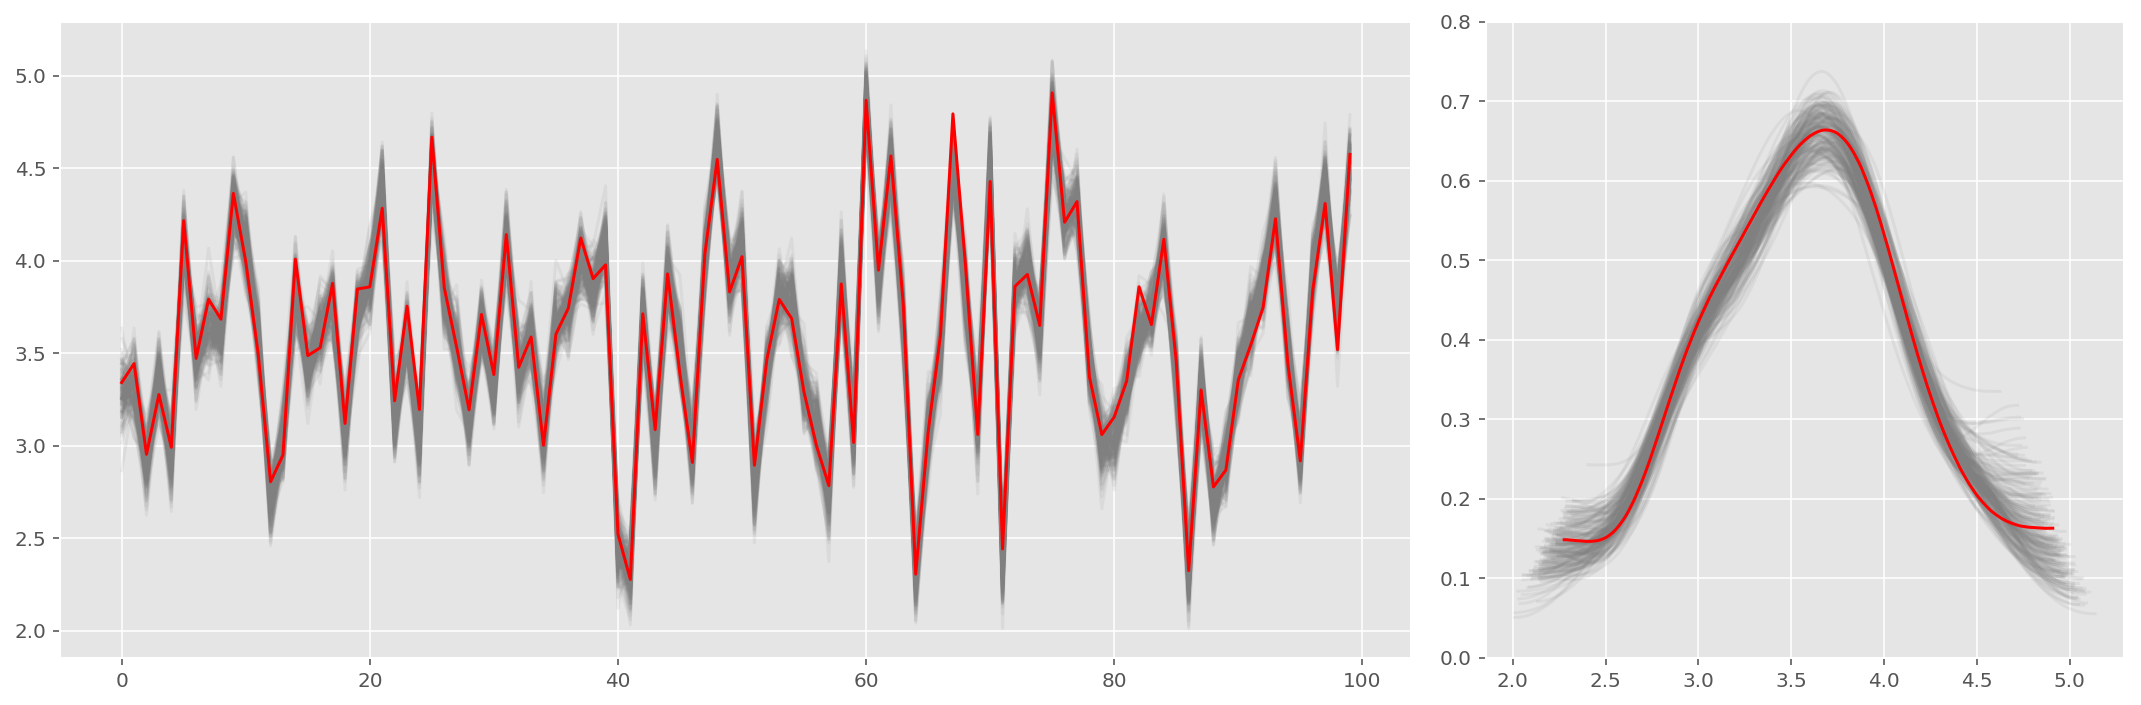

In [18]:
# OOS prediction with no missing predictor
n1 = 100
x_new = np.random.randn(n1, 2) + Xmu_
y_test = alpha_ + sd_ * np.random.randn(n1) + np.dot(x_new, beta_.T)

with model:
    X_test = pm.Normal('X_test', mu=Xmu, sd=1., observed=x_new)
    # since X_test is fully observed, this is the same as doing 
    # X_test = x_new
    mu1 = alpha + tt.dot(X_test, beta)
    
    y1 = pm.Normal('y1', mu=mu1, sd=sd, shape=(n1,))
    ppc1 = pm.sample_ppc(trace, vars=[y1], samples=200)
    
ax0, ax1 = plot_predict(ppc1['y1'], y_test)
ax1.set_ylim(0, .8);

When there is no missing information in $X_{new}$, we can see the prediction uncertainty is small.

100%|██████████| 200/200 [00:02<00:00, 81.37it/s]


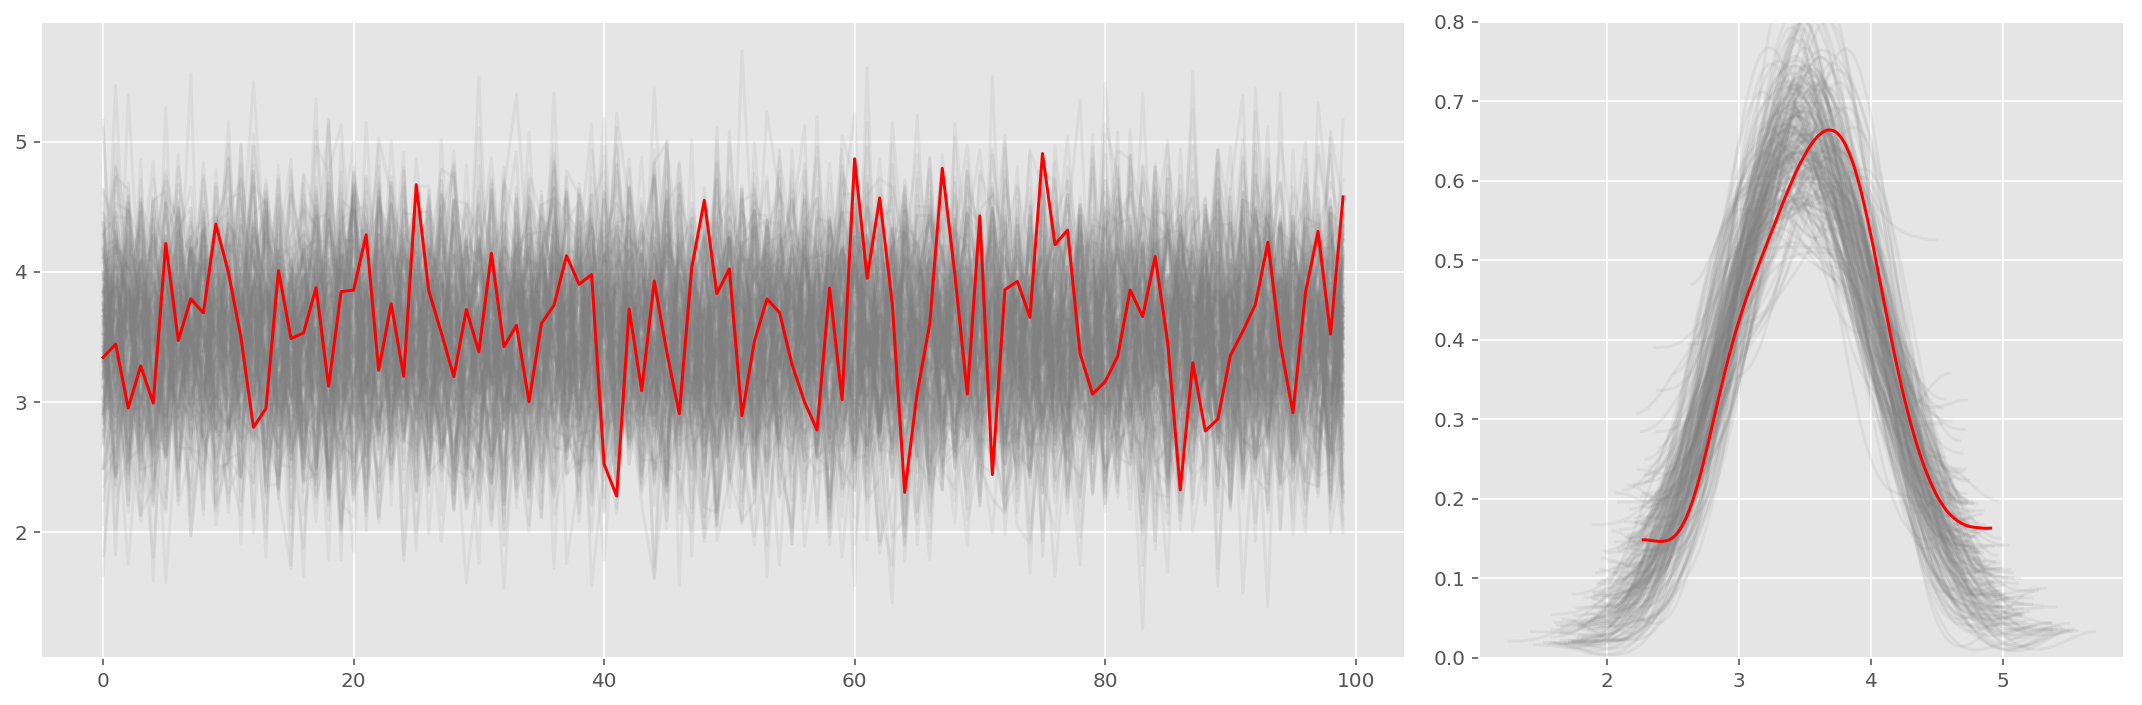

In [19]:
# OOS prediction with missing both predictors
with model:
    # Careful of the shape here. 
    # As the shape broadcasting might not work automatically
    X_mask = pm.Normal('X_mask', mu=Xmu, sd=1., shape=(n1, 2))
    mu2 = alpha + tt.dot(X_mask, beta)
    
    y2 = pm.Normal('y2', mu=mu2, sd=sd, shape=(n1,))
    ppc2 = pm.sample_ppc(trace, vars=[y2], samples=200)

ax0, ax1 = plot_predict(ppc2['y2'], y_test)
ax1.set_ylim(0, .8);

And if there is no information of $X_{new}$, the prediction we get is at least in a reasonable range.

100%|██████████| 200/200 [00:02<00:00, 75.15it/s]


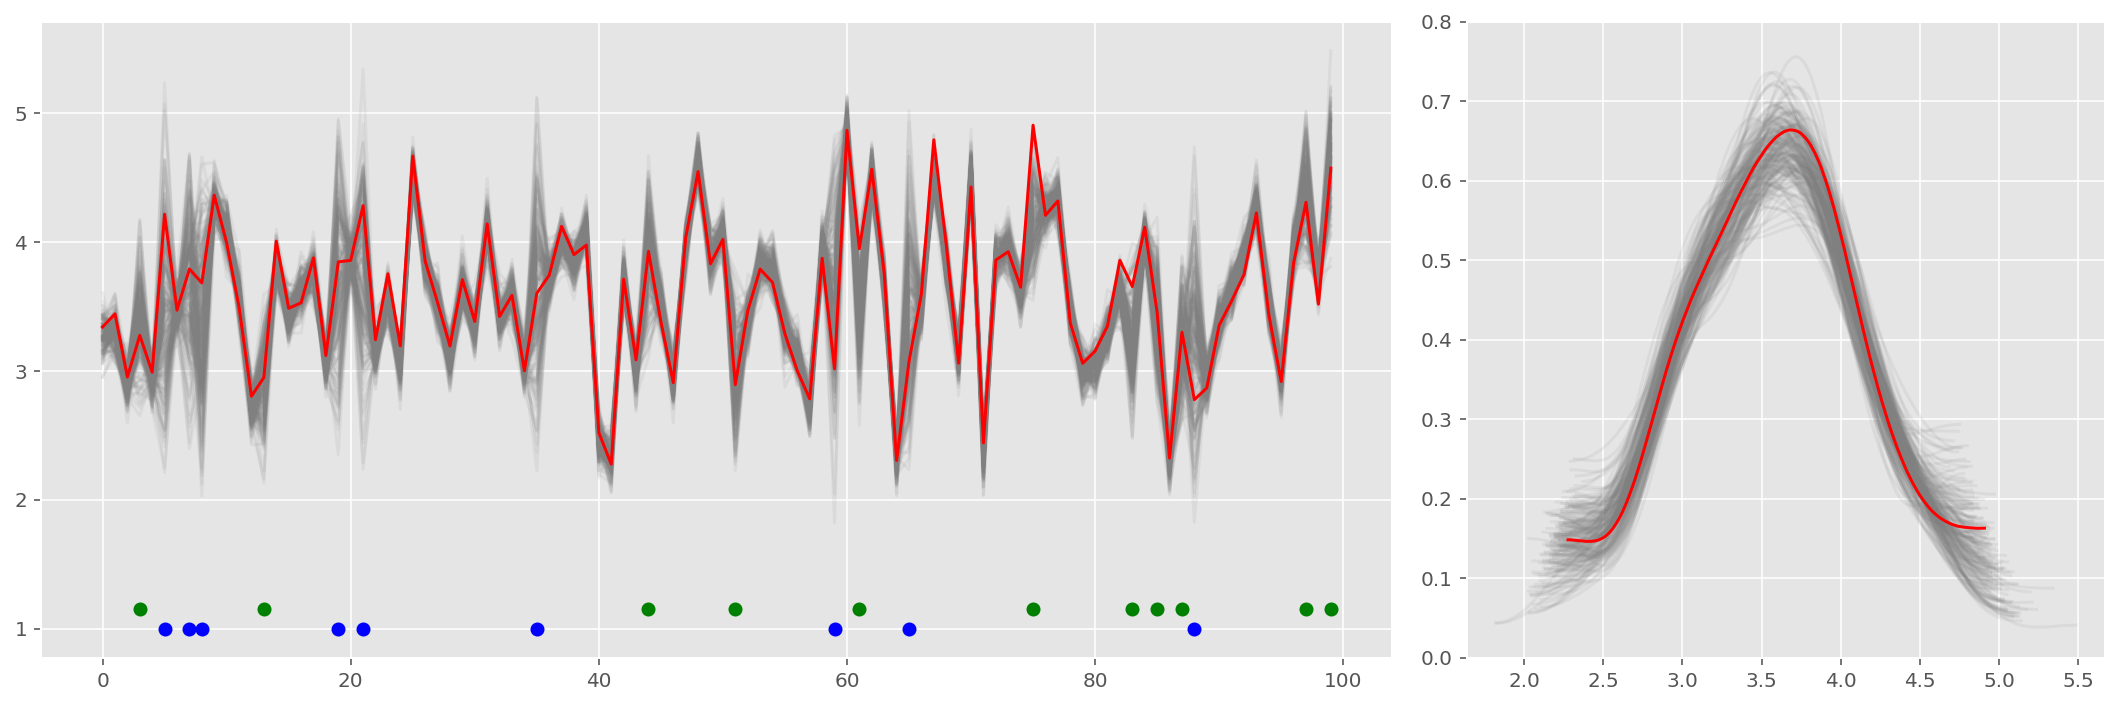

In [20]:
#OOS prediction with part of the predictors missing
mask2 = np.array(np.random.rand(n1, 2) < .1, dtype=int)

with model:
    X_mask3 = pm.Normal('X_mask3', mu=Xmu, sd=1., shape=(n1, 2))
    Xpred = X_mask3*mask2 + x_new*(1-mask2)
    mu3 = alpha + tt.dot(Xpred, beta)
    
    y3 = pm.Normal('y3', mu=mu3, sd=sd, shape=(n1,))
    ppc3 = pm.sample_ppc(trace, vars=[y3], samples=200)

ax0, ax1 = plot_predict(ppc3['y3'], y_test)

ax0.plot(np.where(mask2[:, 0]), 1, 'o', color='b');
ax0.plot(np.where(mask2[:, 1]), 1.15, 'o', color='g');
ax1.set_ylim(0, .8);

Unsurprisingly, prediction uncertainty is larger when there is missing information in the predictor. Another interesting point to make is that the prediction uncertainty is larger when a value is missing in the first column (blue dots) of $X$ than in the second column (green dots): the first column of $X$ contains more information about $y$. 

### Further reading:
* [Posterior Predictive Check in PyMC3](http://docs.pymc.io/notebooks/posterior_predictive.html)  
* [Great discussion on PPC between Andrew Gelman and Sander Greenland](http://andrewgelman.com/2014/08/11/discussion-sander-greenland-posterior-predictive-checks/)  
* [A Unified Treatment of Predictive Model Comparison (by Michael Betancourt)](https://arxiv.org/pdf/1506.02273.pdf)  